Refer to the Sage Worksheet at https://goo.gl/dXarsP to understand the expression that has been used to arrive at the solution for collisional damping using linear theory.

In [1]:
import numpy as np
import pylab as pl
from scipy.integrate import odeint
import h5py
%matplotlib inline

In [2]:
# Setting plot parameters:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [3]:
# Setting the variables in the maxwell distribution
mass_particle      = 1 # mass of particle
boltzmann_constant = 1 # boltzmann-constant
T_background       = 1 # background temperature
rho_background     = 1 # background density

# k for the mode in fourier space
k   = 2*np.pi

# Collisional time-scale tau
tau = 0.005

In [4]:
# The maxwell Boltzmann function
def f_0(v):
    return (np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_background))*\
            np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_background))
           )

In [5]:
# Assign the maxim and minimum velocity for the velocity grid
velocity_max =  +60
velocity_min =  -60

In [6]:
# Set the divisions for the velocity grid
N_vel      = 1201
velocity_x = np.linspace(velocity_min, velocity_max, N_vel)
dv         = velocity_x[1] - velocity_x[0]

In [7]:
def linearized_collision_operator(f):
    delta_T     = np.sum(f * (velocity_x**2 - T_background)) * dv/rho_background
    delta_rho   = np.sum(f) * dv
    delta_v     = np.sum(f * velocity_x) * dv/rho_background
    
    expr_term_1 = np.sqrt(2 * mass_particle**3) * delta_T * rho_background * velocity_x**2
    expr_term_2 = 2 * np.sqrt(2 * mass_particle) * boltzmann_constant * delta_rho * T_background**2
    expr_term_3 = 2 * np.sqrt(2 * mass_particle**3) * rho_background * delta_v * velocity_x * T_background
    expr_term_4 = - np.sqrt(2 * mass_particle) * boltzmann_constant * delta_T * rho_background * T_background
    
    C_f = (((expr_term_1 + expr_term_2 + expr_term_3 + expr_term_4)*\
           np.exp(-mass_particle * velocity_x**2/(2 * boltzmann_constant * T_background))/\
           (4 * np.sqrt(np.pi * T_background**5 * boltzmann_constant**3)) - f
           )/tau
          )
    
    return C_f

In [8]:
# The expressions used below are only valid for all background parameters at unity:

def diff_delta_f(Y,t):
    f_r = Y[:N_vel]
    f_i = Y[N_vel:]

    f     = f_r + 1j * f_i
    C_f   = linearized_collision_operator(f)
    C_f_r = C_f.real
    C_f_i = C_f.imag
    
    dYdt =np.concatenate([(k * velocity_x * f_i)  + C_f_r,\
                          -(k * velocity_x * f_r) + C_f_i \
                         ], axis = 0
                        )
    
    return dYdt 

In [9]:
# Set the Initial Conditions for delta f(v,t) here

delta_f_initial         = np.zeros(2*N_vel)

delta_f_initial[:N_vel] = 1e-5 * f_0(velocity_x) # Real Part
delta_f_initial[N_vel:] = 2e-5 * f_0(velocity_x) # Imaginary Part

In [10]:
delta_rho_r = np.sum(delta_f_initial[:N_vel])*dv
delta_rho_i = np.sum(delta_f_initial[N_vel:])*dv
N_pos       = 8192
x           = np.linspace(0, 1, N_pos)

In [11]:
# Setting the parameters for time here
final_time = 0.15
dt         = 0.002
time       = np.arange(0, final_time, dt)

In [12]:
# Variable for temperorily storing the real and imaginary parts of delta f used for odeint
initial_conditions_delta_f = np.zeros(2 * N_vel)
old_delta_f                = np.zeros(2 * N_vel)
data = np.zeros(time.size)

In [13]:
for time_index, t0 in enumerate(time):
    if(time_index%100==0):
        print("Computing for TimeIndex = ", time_index)
    t0 = time[time_index]
    if (time_index == time.size - 1):
        break
    t1 = time[time_index + 1]
    t = [t0, t1]

    if(time_index == 0):
        initial_conditions_delta_f = delta_f_initial.copy()
        
    else:
        initial_conditions_delta_f= old_delta_f.copy()
        
    # Integrating delta f
    temporary_delta_f = odeint(diff_delta_f, initial_conditions_delta_f,\
                               t, rtol = 1e-20, atol = 1e-17
                              )[1]
    
    rho_r = np.sum(temporary_delta_f[:N_vel])*dv
    rho_i = np.sum(temporary_delta_f[N_vel:])*dv

    data[time_index] = np.max(rho_r*np.cos(k*x) - rho_i*np.sin(k*x))
    # Saving the solution for to use it for the next time step
    old_delta_f = temporary_delta_f.copy()

Computing for TimeIndex =  0


In [14]:
print(temporary_delta_f.size)
f_dist = np.zeros([N_pos, N_vel])
for i in range(N_vel):
    f_dist[:, i] = temporary_delta_f[i] * np.cos(k*x) -\
                   temporary_delta_f[i + N_vel] * np.sin(k*x)
        
print(f_dist.shape)

2402
(8192, 1201)


In [15]:
import h5py

h5f = h5py.File('linear_theory_Nx_8192.h5', 'w')
h5f.create_dataset('f_dist', data = f_dist)
h5f.close()

1.4591887895398613e-05

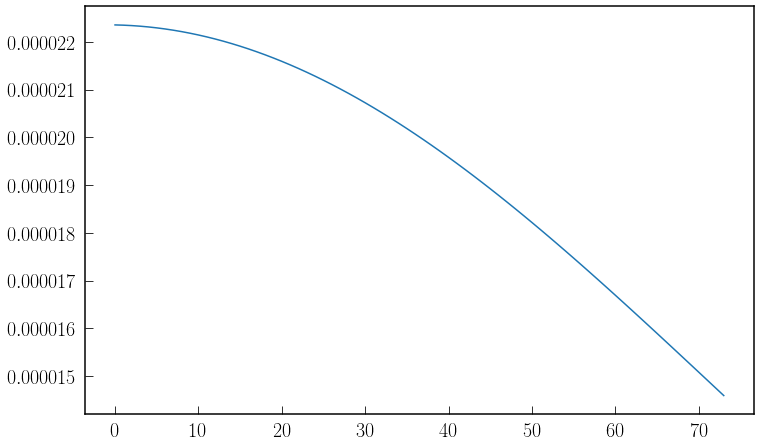

In [16]:
velocity_x, x = np.meshgrid(velocity_x, x)
x.shape
pl.plot(data[:-1])

data[73]

In [17]:
f_analytic = (1e-5 * np.cos(k*(x - velocity_x*t0)) -\
              2e-5 * np.sin(k*(x - velocity_x*t0))
             )*np.exp(-0.5*velocity_x**2)/np.sqrt(2*np.pi)              

/home/speed/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


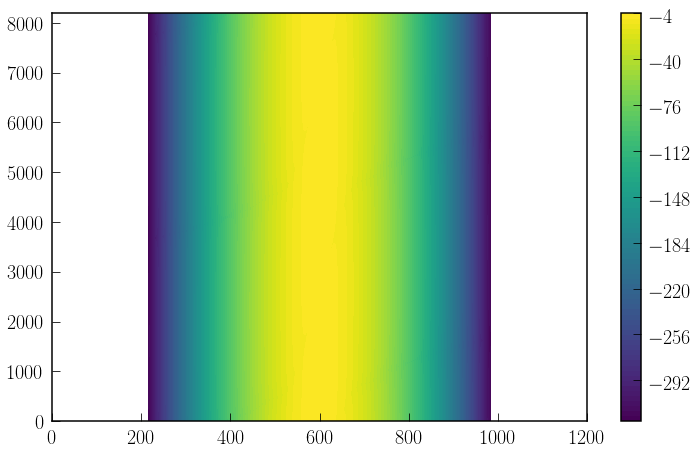

In [18]:
error = abs(f_dist - f_analytic)
pl.contourf(np.log10(error), 100)
pl.colorbar()

In [19]:
np.max(error)

1.2831674635216576e-06

In [20]:
t0

0.14799999999999999